# Example: Static inverse free-boundary equilibrium calculations (in SPARC)

---

Here we will generate an equilibrium (find coil currents with the inverse solver) in a SPARC-like tokamak. 

The machine description comes from files located [here](https://github.com/cfs-energy/SPARCPublic).

The equilbirium\profile parameters are **completely made up** - please experiment on your own and change them to more realistic values as you please!

### Import packages

In [1]:
import os
import matplotlib.pyplot as plt
import freegs4e
import numpy as np

### Create the machine object

In [2]:
# set paths
os.environ["ACTIVE_COILS_PATH"] = f"../machine_configs/SPARC/SPARC_active_coils.pickle"
os.environ["PASSIVE_COILS_PATH"] = f"../machine_configs/SPARC/SPARC_passive_coils.pickle"
os.environ["WALL_PATH"] = f"../machine_configs/SPARC/SPARC_wall.pickle"
os.environ["LIMITER_PATH"] = f"../machine_configs/SPARC/SPARC_limiter.pickle"

In [3]:
# Now the machine can actually be built:
from freegsnke import build_machine
tokamak = build_machine.tokamak()

No coil named Solenoid among the active coils.
No probe configuration is provided


### Instantiate an equilibrium

In [5]:
from freegsnke import equilibrium_update

eq = equilibrium_update.Equilibrium(
    tokamak=tokamak,      # provide tokamak object
    Rmin=1.1, Rmax=2.7,   # radial range
    Zmin=-1.8, Zmax=1.8,  # vertical range
    nx=129,                # number of grid points in the radial direction (needs to be of the form (2**n + 1) with n being an integer)
    ny=129,                # number of grid points in the vertical direction (needs to be of the form (2**n + 1) with n being an integer)
    # psi=plasma_psi
)

### Instantiate a profile object

In [6]:
# initialise the profiles
from freegsnke.jtor_update import ConstrainPaxisIp
profiles = ConstrainPaxisIp(
    eq=eq,        # equilibrium object
    paxis=5e4,    # pressure on axis
    Ip=8.7e6,       # plasma current
    fvac=0.5,     # fvac = rB_{tor}
    alpha_m=1.8,  # profile function parameter
    alpha_n=1.2   # profile function parameter
)

### Load the static nonlinear solver

In [7]:
from freegsnke import GSstaticsolver
GSStaticSolver = GSstaticsolver.NKGSsolver(eq)    

### Constraints

In [8]:
import freegs4e

# set X-point locations
Rx = 1.55
Zx = 1.15
xpoints = [(Rx, -Zx),   
           (Rx,  Zx)]

# set any desired isoflux constraints with format (R1, Z1, R2, Z2), where (R1, Z1) and (R2, Z2) are 
# desired to be on the same flux contour.
Rmid = 2.4    # outboard midplane radius
Rin = 1.3    # inboard midplane radius
isoflux = [(Rx,Zx, Rx,-Zx),     # link X-points
           (Rmid, 0, Rin, 0.0), # link inner and outer midplane points
           (Rmid, 0, Rx, Zx),   # link outer midplane point and X-point
           (Rin, 0, Rx, Zx),   # link inner midplane point and X-point
          #  (Rmid, 0, Rx, -Zx),   # link outer midplane point and X-point
          #  (Rin, 0, Rx, -Zx),   # link inner midplane point and X-point
           (Rx, Zx, 1.7, 1.5),   # link strikepoint
           (Rx, Zx, 1.7, -1.5),   # link strikepoint
          #  (Rx, -Zx, 1.32, -1.21),   # link strikepoint
          #  (Rx, -Zx, 1.68, -1.45),   # link strikepoint
]

           
# instantiate the constrain object
constrain = freegs4e.control.constrain(xpoints=xpoints,
                                         isoflux=isoflux,
                                       # psivals=psivals, # not used
                                         gamma=1e-10       # regularisation factor
                                         )

### The inverse solve

In [9]:
GSStaticSolver.solve(eq=eq, 
                     profiles=profiles, 
                     constrain=constrain, 
                     target_relative_tolerance=1e-6,
                     verbose=True, # print output
                     picard=True, 
                     )

(-2.0, 2.0)

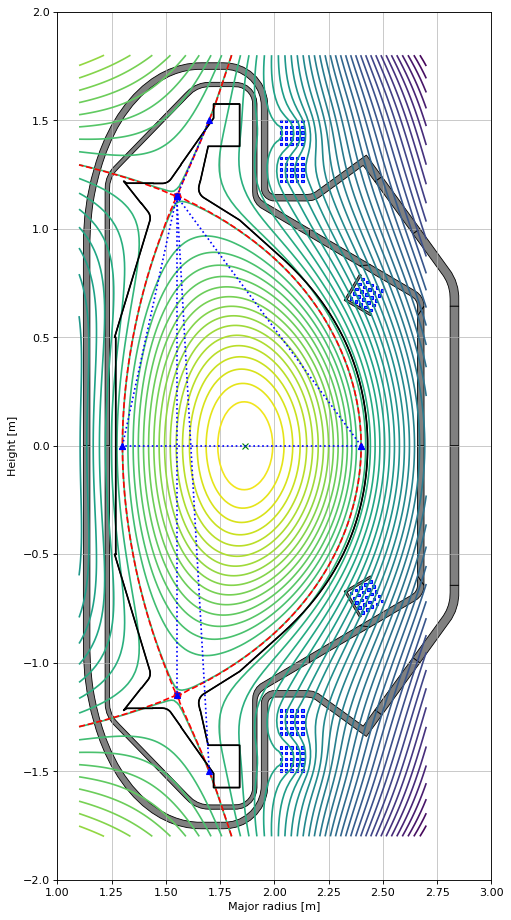

In [10]:
fig1, ax1 = plt.subplots(1, 1, figsize=(7, 15), dpi=80)

ax1.grid(zorder=0, alpha=0.75)
ax1.set_aspect('equal')
eq.tokamak.plot(axis=ax1,show=False)                                                          # plots the active coils and passive structures
ax1.fill(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, facecolor='w', zorder=0)   # plots the limiter
eq.plot(axis=ax1,show=False)                                                                  # plots the equilibrium
constrain.plot(axis=ax1, show=False)                                                          # plots the contraints
ax1.set_xlim(1.0, 3.0)
ax1.set_ylim(-2.0, 2.0)


In [11]:
eq.tokamak.getCurrents()

# # save coil currents to file
# import pickle
# with open('simple_diverted_currents_PaxisIp.pk', 'wb') as f:
#     pickle.dump(obj=inverse_current_values, file=f)

{'CS1I': -67718.39725404991,
 'CS1O': -61822.094624201636,
 'CS2': -164825.2180895493,
 'CS3': 58563.61082682121,
 'PF1': 101405.36859066812,
 'PF2': 88586.87363630212,
 'PF3': -98580.42878809175,
 'PF4': -139311.3479527865,
 'DV1': 19327.706570623854,
 'DV2': -8297.310780034652,
 'VS1': 1.5431859991046903e-06,
 'vacuum_vessel_0': 0,
 'vacuum_vessel_1': 0,
 'vacuum_vessel_2': 0,
 'vacuum_vessel_3': 0,
 'vacuum_vessel_4': 0,
 'vacuum_vessel_5': 0,
 'vacuum_vessel_6': 0,
 'vacuum_vessel_7': 0,
 'vacuum_vessel_8': 0,
 'vacuum_vessel_9': 0,
 'vacuum_vessel_10': 0,
 'vacuum_vessel_11': 0,
 'vacuum_vessel_12': 0,
 'vacuum_vessel_13': 0,
 'vacuum_vessel_14': 0,
 'vacuum_vessel_15': 0,
 'VSC_coil_cover0': 0,
 'VSC_coil_cover1': 0}